# Individual Image Analysis Example
## Author: Yoon Ah Shin
### Date created: 2022.01.13
### Last updated: 2022.01.13

In [1]:
# import modules
%matplotlib notebook
# comment out the above line to deactivate interactive plotting
import finger_analysis as fa
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
# pytesseract needs to be directed to the local installation of Tesseract OCR
# this is done in the scale.py file of the finger_analysis package

## How to use finger_analysis package for image analysis

Passing the image filename without extension to `fa.fingers.get_edges_in_img()` crops data bar area in the image and returns edges detected in the image. The default value of the y-coordinate of the top of data bar area is 690. 

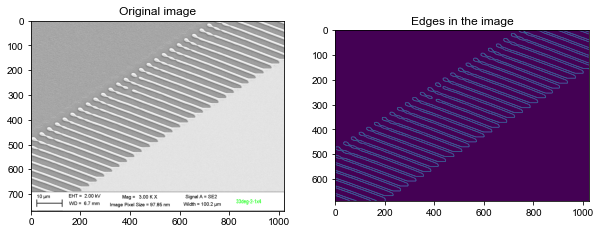

In [2]:
# Input argument 
filename = '33deg_040' # image filename without extension 
# Functions
edges = fa.fingers.get_edges_in_img(filename, data_bar_top=690) # use this function to detect edges in the image
img = plt.imread(filename+'.tif') # original image
# Show images
plt.figure(figsize=(10,7.5))
plt.subplot(1,2,1, title='Original image')
plt.imshow(img)
plt.subplot(1,2,2, title='Edges in the image')
plt.imshow(edges)

The darker area in the original image is the underlying MgO substrate while the brighter area is single-crystal Ni thin film. The parallel array of Ni wires were formed due to the development of fingering instability during retraction of the patterned film edge. The patterned film edge, which had a sinusoidal perturbation, can be seen through the trace left on the substrate surface. The wires that formed due to fingering instability will be called 'wires' and the exposed susbtrate surface that are separated by the wires will be referred to as 'fingers'. 

The width of the wires and fingers, the period of fingers, and the propagation distance of fingers will be calculated by using two or three images, which will be described in detail in later sections. The first image will be the edges in the original image or a line drawn across the image. The second/third image will be another lines drawn across the image.

`fa.fingers.get_line_drawn_in_img()` reads in an image with a line drawn and returns an image with only the line. The color of the line drawn must either be 'red' or 'black'.

Note: The red or black lines were drawn using ImageJ. Set line width to 2 for a reliable analysis. When line is drawn with width of 1, it could be too thin to be detected and may give inaccurate result during image analysis. Lastly, when drawing lines, use a keyboard shortcut: command+F

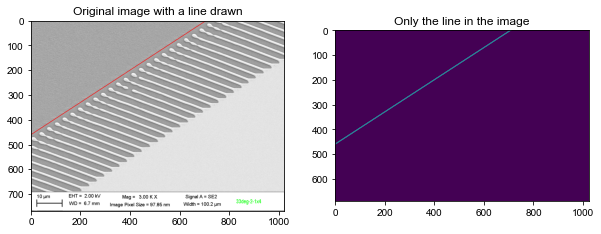

In [3]:
# Input arguments
filename = '33deg_040'
suffix = '_line_1'
line_color = 'r' # 'r' if the color of the line is red and 'k' if the color of the line is black
data_bar_top = 690
# Functions
img_line = plt.imread(filename+suffix+'.tif') # image with a line drawn
line = fa.fingers.get_line_drawn_in_img(filename, suffix, line_color, data_bar_top) # image with only the line
# Show images
plt.figure(figsize=(10,7.5))
plt.subplot(1,2,1, title='Original image with a line drawn')
plt.imshow(img_line)
plt.subplot(1,2,2, title='Only the line in the image')
plt.imshow(line)

**The goal of image analysis here is to automatically measure the following physical characteristics of the fingers:**
- Propagation direction of the fingers (i.e. orientation of the wires), which will be denoted as $\beta$
- Propagation distance of the fingers, which will be denoted as $d$
- Width of the wires, which will be denoted as $a$
- Width of the fingers (i.e. spacing of the wires), which will be denoted as $b$
- Period of the fingers, which will be denoted as $p$


## 1. Propgation direction of fingers

The `line_orientation` module in the `finger_analysis` package has functions to detect lines in an image, compute the orientation of the detected lines relative to the x-axis and output the result in a pandas data frame. This is done in function `get_finger_orientation()` in the `line_orientation` module. The number of lines detected varies when you change the three input arguments: `threshold`, `minLineLength` and `maxLineGap`.

As mentioned above, during the image analysis, the data bar area is cropped and only the remaining area in the image is analyzed.

One can see the detected lines in the image with labels by setting input argument `show_image` to True, save the image showing the detected lines with labels by setting `save_image` to True, and save the data frame of orientation of the detected lines by setting `save_df` to True. 

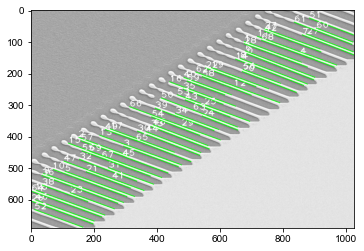

In [4]:
# Input arguments
filename = '33deg_040'
threshold = 100
minLineLength = 100
maxLineGap = 5
data_bar_top = 690
show_image = True
save_image = False
save_df = False
# Function
df_direction = fa.line_orientation.get_finger_orientation(filename, threshold, minLineLength, maxLineGap,\
                                                          data_bar_top, show_image, save_image, save_df)
#df_direction

## 2. Pixel size of the image

When calculating propagation distance of fingers, width of wires and fingers, and period of fingers, pixel size of the image is required.

The `scale` module in the `finger_analysis` package has functions for reading or extracting the pixel size of an image.

- If the pixel size is provided in the data bar area, `fa.scale.get_pixel_size()` returns the stated pixel size and the prefix of the unit.
- If the pixel size is not stated in the data bar area, it can be extracted by reading the number written above the scale bar and by getting the number of pixels in the scale bar. The pixel size of the image is the number written above the scale bar divided by the number of pixels in the scale bar. This is done in the function `fa.scale.extract_pixel_size()`.

In [5]:
# Input arguments
filename = '33deg_040'
data_bar_top = 690
data_bar_bottom = 760
# Function
pixel_size = fa.scale.get_pixel_size(filename, data_bar_top, data_bar_bottom)[0]/1000 # get pixel size of the image
#pixel_size

## 3. Propagation distance of fingers 

As abovementioned, propagation distance of fingers will be calculated using two or three images. 

I developed two different methods for calculating finger propagation distance, which give the same result. Both methods are based on drawing two types of red or black lines in the image and gettting sorted x, y coordinates of intersections of the two types of lines or those of the edges in the image and the lines. From these sorted x, y coordinates, we can calculate the number of pixels between the adjacent intersections (i.e. distances). Then, the actual distances can be obtained by multiplying the pixel size of the image to the number of pixels. 

(The same idea is used when calculating the width of wires and fingers, and the peirod of fingers, which will be shown in the later section.) 

The difference between the two methods for calculating finger propagation distance is the way of line drawing.
- In the first method, or the old method, three images are used. The first image is a single line drawn along the initial position of the patterned edge, as shown in the image with title 'line_1'. The second image is lines drawn along the propagation direction of fingers and the lines intersect the corners of the finger tips, as shown in the image with title 'line_2'. The third image is edges detected in the image, as shown in the image with title 'edges in the image'. These three images are shown in **section 3.1.1.** The intersections of the line_1 image and the line_2 image give the x,y coordinates of the initial positions of the individual fingers, while those of the line_2 image and the edges in the image provide the x,y coordinates of the corners of the finger tips. The sorted data frame of x,y coordinates of the intersections can be obtained using `fa.fingers.get_coords_intersections()`, as described in **section 3.1.2.** The function also displays a labeled image of these intersections. Distance between the initial position of the finger and the position of the corner corresponds to the propagation distance of the individual finger. The actual propagation distance of the finger is obtained by multiplying the pixel size to the distance. This is done in function `fa.fingers.propagation_distance_of_fingers()`, as illustrated in **section 3.1.3.**


- In the second method, or the new method, two images are used. The first image is lines drawn parallel to the initial edge orientation with a line drawn along the initial position of the patterned edge and lines drawn at the corners of the finger tips, as shown in the image with title 'new_line_1'. The second image is a line drawn perpendicular to the initial edge orientation, as seen in the image with title 'new_line_2'. These images are shown in **section 3.2.1.** Then, we can get x, y coordinates of the intersections of the new_line_1 image and the new_line_2 image as shown in **section 3.2.2.**, from which distances, $q$, can be calculated. We can automatically measure the finger propagation direction, $\beta$, as discussed in **section 1** and **section 3.2.3.** Also, we can automatically measure the initial edge orientation, $\alpha$, by using the function `fa.line_orientation.get_red_line_orientation()` or `fa.line_orientation.get_black_line_orientation()` depending on the color of the line drawn on the image, as illustrated in **section 3.2.4.** The propagation distance of fingers is: $d=\frac{q}{\sin(\alpha+\beta)}$. This is done in function `fa.fingers.new_method_propagation_distance_of_fingers()`, as shown in **section 3.2.5.**

The old method can only be applied in a direct templating regime where the finger morphology is regular and is directly controlled by the template period, while the new method can be applied to the full range of templating. In addition, the new method is more time efficient than the old method since a less number of lines are required in calculating the propagation distances in the new method.

## 3.1. The first method 

### 3.1.1. Get the three images 

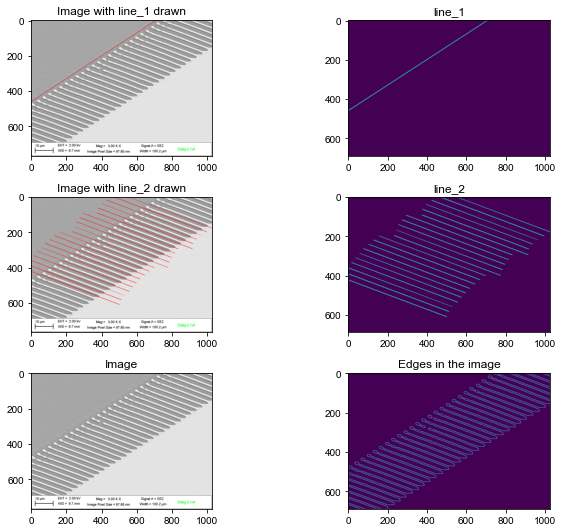

In [6]:
# Input arguments 
filename = '33deg_040'
suffix_1 = '_line_1'
suffix_2 = '_line_2' 
line_color = 'r' # 'r' if the color of the line is red and 'k' if the color of the line is black
data_bar_top = 690
# Functions
img_line_1 = plt.imread(filename+suffix_1+'.tif') # image with line_1 drawn
img_line_2 = plt.imread(filename+suffix_2+'.tif') # image with line_2 drawn
img = plt.imread(filename+'.tif') # original image
line_1 = fa.fingers.get_line_drawn_in_img(filename, suffix_1, line_color, data_bar_top) # image of line_1
line_2 = fa.fingers.get_line_drawn_in_img(filename, suffix_2, line_color, data_bar_top) # image of line_2
edges = fa.fingers.get_edges_in_img(filename, data_bar_top) # edges detected in the image
# Show images
plt.figure(figsize=(10,7.5))
plt.subplot(3,2,1, title='Image with line_1 drawn')
plt.imshow(img_line_1)
plt.subplot(3,2,2, title='line_1')
plt.imshow(line_1)
plt.subplot(3,2,3, title='Image with line_2 drawn')
plt.imshow(img_line_2)
plt.subplot(3,2,4, title='line_2')
plt.imshow(line_2)
plt.subplot(3,2,5, title='Image')
plt.imshow(img)
plt.subplot(3,2,6, title='Edges in the image')
plt.imshow(edges)
plt.tight_layout()

### 3.1.2. Get sorted data frame of x,y coordinates of the intersections 

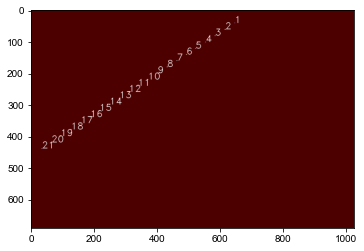

In [7]:
# Intersections between line_1 and line_2
sorted_df_1 = fa.fingers.get_coords_intersections(line_1, line_2, show_overlay=True)
#sorted_df_1

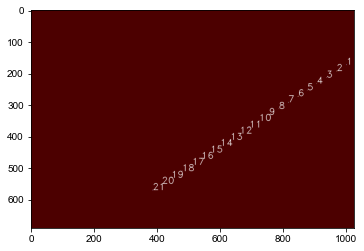

In [8]:
# Intersections between line_2 and edges in the image
sorted_df_2 = fa.fingers.get_coords_intersections(line_2, edges, show_overlay=True)
#sorted_df_2

### 3.1.3. Calculate the propagation distance of fingers 

In [9]:
d = fa.fingers.propagation_distance_of_fingers(sorted_df_1, sorted_df_2, pixel_size)
#d

## 3.2. The second method 

### 3.2.1. Get the two images

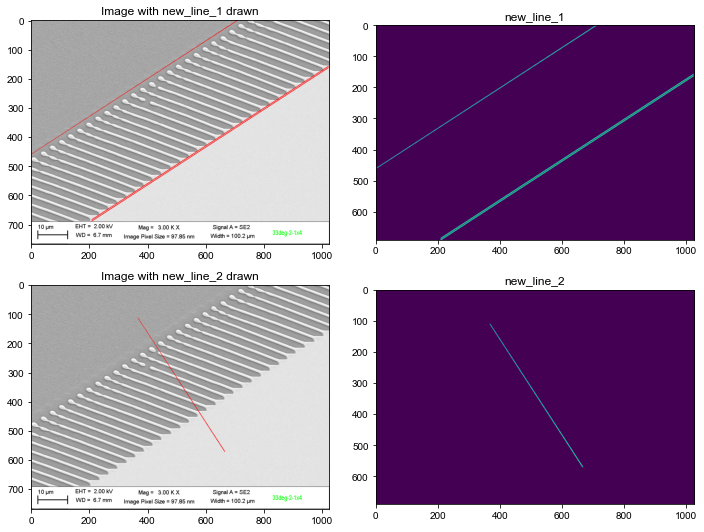

In [10]:
# Input arguments 
filename = '33deg_040'
suffix_new_1 = '_new_line_1'
suffix_new_2 = '_new_line_2' 
line_color = 'r' # 'r' if the color of the line is red and 'k' if the color of the line is black
data_bar_top = 690
# Functions
img_new_line_1 = plt.imread(filename+suffix_new_1+'.tif') # image with new_line_1 drawn
img_new_line_2 = plt.imread(filename+suffix_new_2+'.tif') # image with new_line_2 drawn
new_line_1 = fa.fingers.get_line_drawn_in_img(filename, suffix_new_1, line_color, data_bar_top) # image of line_1
new_line_2 = fa.fingers.get_line_drawn_in_img(filename, suffix_new_2, line_color, data_bar_top) # image of line_2
# Show images
plt.figure(figsize=(10,7.5))
plt.subplot(2,2,1, title='Image with new_line_1 drawn')
plt.imshow(img_new_line_1)
plt.subplot(2,2,2, title='new_line_1')
plt.imshow(new_line_1)
plt.subplot(2,2,3, title='Image with new_line_2 drawn')
plt.imshow(img_new_line_2)
plt.subplot(2,2,4, title='new_line_2')
plt.imshow(new_line_2)
plt.tight_layout()

### 3.2.2. Get sorted data frame of x,y coordinates of the intersections 

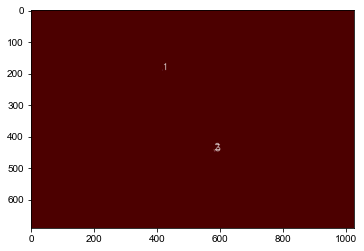

In [11]:
# Intersections between new_line_1 and new_line_2
sorted_df = fa.fingers.get_coords_intersections(new_line_1, new_line_2, show_overlay=True)
reverse_sort = False # True if the fingers propagate in the top-left direction.
if reverse_sort == True:
    sorted_df = sorted_df.iloc[::-1].reset_index(drop=True)
#sorted_df

### 3.2.3. Propagation direction of the fingers

In [12]:
beta = df_direction['Finger orientation (deg)'].mean() # refer to the section 1. 
#beta

### 3.2.4. Initial edge orientation

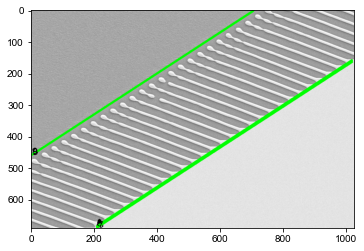

In [13]:
# Input arguments
filename = '33deg_040'
suffix_alpha = '_new_line_1'
threshold_alpha = 100
minLineLength_alpha = 100
maxLineGap_alpha = 5
data_bar_top = 690
img_show = True
# Function
df_alpha = fa.line_orientation.get_red_line_orientation(filename, suffix_alpha, threshold_alpha,\
                                                        minLineLength_alpha, maxLineGap_alpha,\
                                                        data_bar_top, img_show)
alpha = df_alpha['Red line orientation (deg)'].mean()
#alpha

### 3.2.5. Calculate the propagation distance of fingers using the new method

In [14]:
d_new_method = fa.fingers.new_method_propagation_distance_of_fingers(alpha, beta, sorted_df, pixel_size)
#d_new_method

## 4. Wire width, finger width, and finger period

The width of wires, the width and period of fingers can be calculated based on the same idea that was used in the calculation of propagation distance of fingers. A red or black line is drawn across the fingers with orientation aligned along the initial edge orientation, as shown in the image with title '_line2' in **section 4.1.** Intersections of the line and the edges of the image returns the x, y coordinates, as shown in **section 4.2.** These coordinates are then used to calculate the wire width, finger width, and finger period along the initial edge orientation, which are described in **section 4.3.** Since the fingers propagate at an angle relative to the initial edge orientation, $\alpha + \beta$, the actual values of the wire width, finger width, and finger period are obtained by multiplying $\sin(\alpha + \beta)$ to the values obtained along the initial edge orientation. 

### 4.1. Get the two images

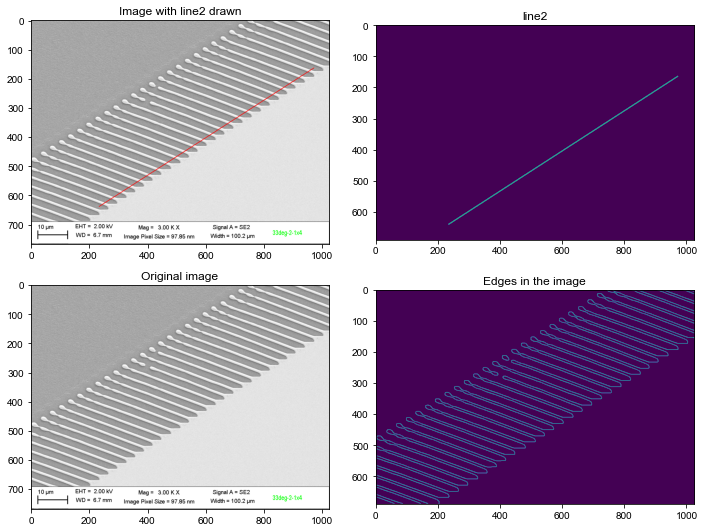

In [15]:
# Input arguments 
filename = '33deg_040'
suffix_a_b_p = '_line2'
line_color = 'r' # 'r' if the color of the line is red and 'k' if the color of the line is black
data_bar_top = 690
# Functions
img = plt.imread(filename+'.tif') # original image
img_line2 = plt.imread(filename+suffix_a_b_p+'.tif') # image with line2 drawn
line2 = fa.fingers.get_line_drawn_in_img(filename, suffix_a_b_p, line_color, data_bar_top) # image of line2
edges = fa.fingers.get_edges_in_img(filename, data_bar_top=690) # edges detected in the image
# Show images
plt.figure(figsize=(10,7.5))
plt.subplot(2,2,1, title='Image with line2 drawn')
plt.imshow(img_line2)
plt.subplot(2,2,2, title='line2')
plt.imshow(line2)
plt.subplot(2,2,3, title='Original image')
plt.imshow(img)
plt.subplot(2,2,4, title='Edges in the image')
plt.imshow(edges)
plt.tight_layout()

### 4.2. Get sorted data frame of x,y coordinates of the intersections

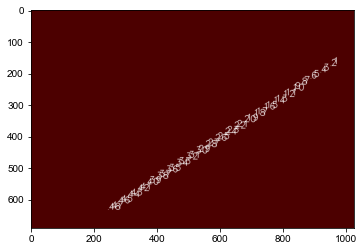

In [16]:
sorted_df_a_b_p = fa.fingers.get_coords_intersections(line2, edges, show_overlay=True)
#sorted_df_a_b_p

### 4.3. Calculate wire width, finger width, and finger period

In [17]:
# Values measured along initial edge orientation, alpha
a_along_alpha = fa.fingers.get_wire_widths_along_line(sorted_df_a_b_p, pixel_size) # wire width along alpha
b_along_alpha = fa.fingers.get_finger_widths_along_line(sorted_df_a_b_p, pixel_size) # finger width along alpha
p_along_alpha = fa.fingers.get_finger_periods_along_line(sorted_df_a_b_p, pixel_size) # finger period along alpha
# Multiplication factor
m = np.sin(np.deg2rad(abs(alpha)+abs(beta))) # refer to section 1 and 3.2.3 for beta and section 3.2.4 for alpha
# Actual values 
a = a_along_alpha*m # actual wire width
b = b_along_alpha*m # actual finger width
p = p_along_alpha*m # actual finger period

In [18]:
#a

In [19]:
#b

In [20]:
#p